In [24]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.conv_learner import *
from fastai.dataset import *
from IPython.core.debugger import set_trace
import sklearn.metrics as metrics
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

This was only trained and validated on the training data for ISIC 2017, their validation and test sets were not used. The next notebook will incorporate all three of the splits to ensure we are not overfitting

# Data

In [25]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax


In [26]:
PATH = Path('/home/sean/hpc-home/skin_cancer')
xpath = PATH / 'ISIC-2017_Training_Data'
ypath = PATH / 'ISIC-2017_Training_Part1_GroundTruth'
xpath.exists(), ypath.exists()

(True, True)

## Preprocessing

In [27]:
sz = 128
bs = 64
nw = 4

In [28]:
sorted([x for x in xpath.glob('*.jpg')])[0:10]

[PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0000000.jpg'),
 PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0000001.jpg'),
 PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0000002.jpg'),
 PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0000003.jpg'),
 PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0000004.jpg'),
 PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0000006.jpg'),
 PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0000007.jpg'),
 PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0000008.jpg'),
 PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0000009.jpg'),
 PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0000010.jpg')]

In [32]:
xnames = np.array(sorted([n for n in xpath.glob('*.jpg')]))
ynames = np.array(sorted([y for y in ypath.glob('*.png')]))
len(xnames), len(ynames), xnames[-10:], ynames[-10:]

(2000,
 2000,
 array([PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0015189.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0015190.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0015200.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0015204.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0015219.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0015220.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0015233.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0015260.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0015284.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC-2017_Training_Data/ISIC_0015295.jpg')], dtype=object),
 array([PosixPath('/

In [53]:
sizes = [PIL.Image.open(x).size for x in xnames]

Text(0.5,1,'Col Distributions')

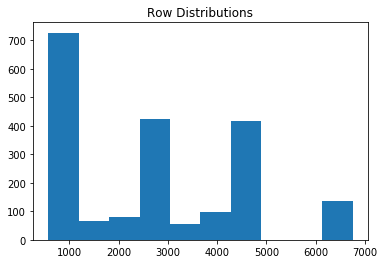

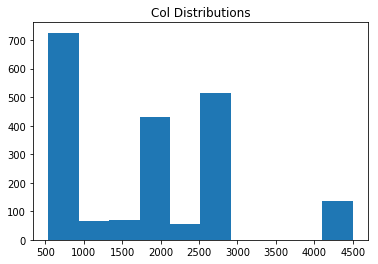

In [73]:
row_sz, col_sz = list(zip(*sizes))
plt.hist(row_sz)
plt.title('Row Distributions')
plt.figure()
plt.hist(col_sz)
plt.title('Col Distributions')

## Data Iterator

In [29]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0    

In [33]:
val_idxs = list(range(int(len(xnames)*.15)))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, xnames, ynames)

In [40]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomDihedral(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [41]:
arch = resnet34

In [44]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
mdata = ImageData(PATH, datasets, bs, num_workers=nw, classes=None)
denorm = mdata.trn_ds.denorm

In [45]:
x,y = next(iter(mdata.trn_dl))
x = denorm(x)

In [46]:
x.shape,y.shape, np.unique(y)

(torch.Size([64, 3, 128, 128]),
 torch.Size([64, 128, 128]),
 array([0., 1.], dtype=float32))

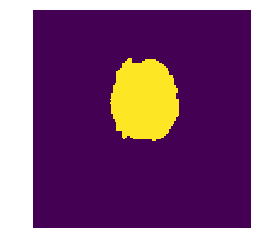

In [52]:
show_img(to_np(y[0,...]))

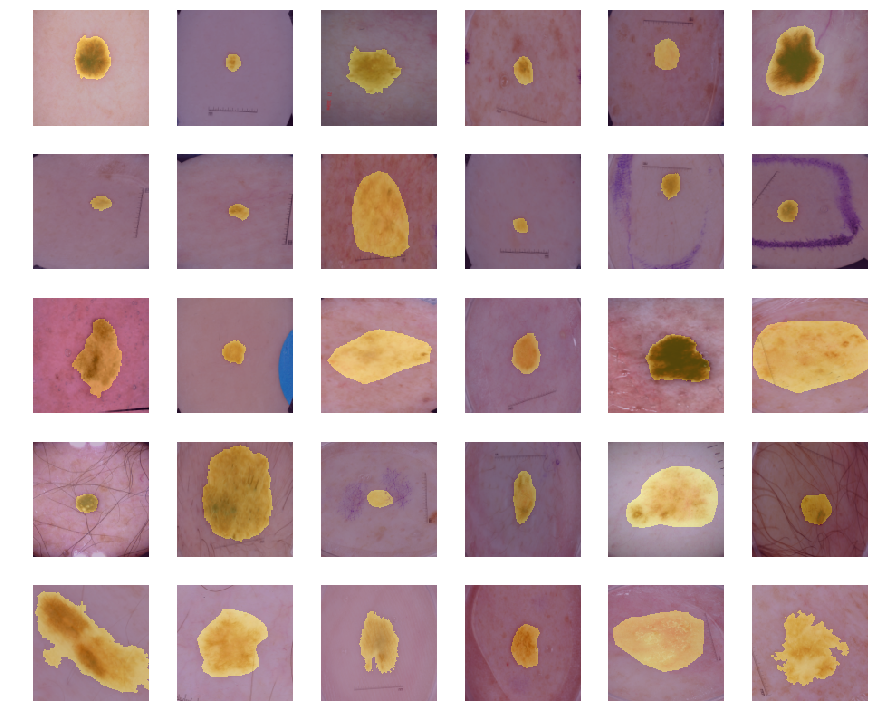

In [77]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.3)
plt.tight_layout(pad=0.1)

In [74]:
mdata.classes

# Model Architecture


In [78]:
cut, lr_cut = model_meta[arch]

In [ ]:
import sklearn.metrics as metrics
def get_base(f=arch,cut_=cut):
    layers = cut_model(f(True), cut_)
    return nn.Sequential(*layers)

def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def jaccard(pred, targs):
    # iou = TP / (TP + FP + FN)
    pred = (pred>0).float()
    return metrics.jaccard_similarity_score(targs, pred)

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [80]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [81]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [82]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [83]:
m_base = get_base()
unet = to_gpu(Unet34(m_base))
models = UnetModel(unet)

In [84]:
learn = ConvLearner(mdata, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [85]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [88]:
[o.features.size() for o in unet.sfs]

[torch.Size([3, 64, 64, 64]),
 torch.Size([3, 64, 32, 32]),
 torch.Size([3, 128, 16, 16]),
 torch.Size([3, 256, 8, 8])]

# Training

In [157]:
def plot_loss(train_losses, val_losses, rec_metrics, num_ep, epoch_iters):
    fig,ax = plt.subplots(2,1,figsize=(8,12))
    ax[0].grid()
    ax[0].plot(list(range(num_ep)), val_losses, label='Validation loss')
    ax[0].plot(list(range(num_ep)),[train_losses[i-1] for i in epoch_iters], label='Training loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='upper right')
    ax[1].plot(list(range(num_ep)),rec_metrics)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(bottom=min(0.5, min(rec_metrics)))
    ax[1].grid()

def plot_training():
    plot_loss(learn.sched.losses, learn.sched.val_losses, 
              list(zip(*learn.sched.rec_metrics))[0], learn.sched.epoch, learn.sched.epochs)
    

Freeze all but the last 'group' of the model. Groups are defined under the hood, the cut_model function uses these groupings as well. 

In [89]:
learn.freeze_to(1) # freeze all but the last 'group' of the model

 93%|█████████▎| 25/27 [04:00<00:19,  9.61s/it, loss=1.39] 

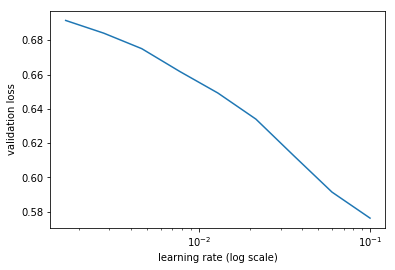

In [90]:
learn.lr_find()
learn.sched.plot()

In [92]:
lr = 4e-2
wd=1e-7
lrs = np.array([lr/100, lr/10, lr])

In [93]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.237256   63.838834  0.358715   0.490015  
    1      0.169525   0.513091   0.866861   0.801288       
    2      0.140568   0.117328   0.955116   0.923544       
    3      0.12651    0.115556   0.950408   0.922862       
    4      0.112813   0.109259   0.951959   0.927375       
    5      0.10397    0.107429   0.951016   0.92667        
    6      0.099747   0.097523   0.960581   0.935505        
    7      0.09442    0.097581   0.956844   0.934758        


[array([0.09758]), 0.9568442757924398, 0.9347584842415184]

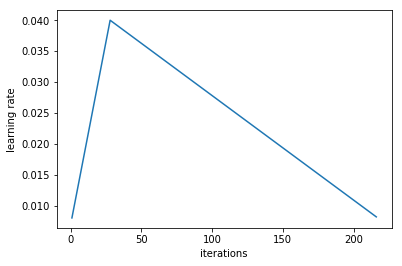

In [95]:
learn.sched.plot_lr()

In [102]:
learn.save('128unet_1')

In [ ]:
learn.load('128unet_1')

In [ ]:
x,y = next(iter(mdata.val_dl))
py = to_np(learn.model(V(x)))

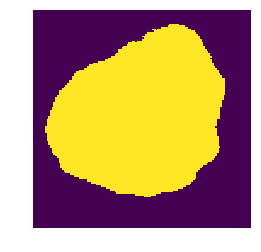

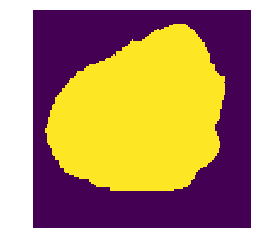

In [169]:
show_img(py[0]>0); show_img(y[0]);

In [108]:
learn.unfreeze()
learn.bn_freeze(True)

In [109]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.078064   0.095725   0.959805   0.937373  
    1      0.079373   0.09263    0.962441   0.939861        
    2      0.084398   0.096148   0.959342   0.936545        
    3      0.084866   0.098666   0.954776   0.932967        
    4      0.081552   0.09124    0.959544   0.938854        
    5      0.078224   0.086785   0.963335   0.942033        
    6      0.076461   0.08771    0.962656   0.941413        
    7      0.075539   0.088783   0.962247   0.941712        
    8      0.07417    0.087077   0.965014   0.942226        
    9      0.073059   0.087382   0.964466   0.941071        
    10     0.072301   0.087536   0.965283   0.941888        
    11     0.071628   0.086212   0.963987   0.942929        
    12     0.070418   0.0968     0.956855   0.936372        
    13     0.069133   0.091081   0.960982   0.940246        
    14     0.067763   0.086965   0.964694   0.942799        
    15     0.067101   0.087129

[array([0.08609]), 0.96510884364446, 0.943113714107298]

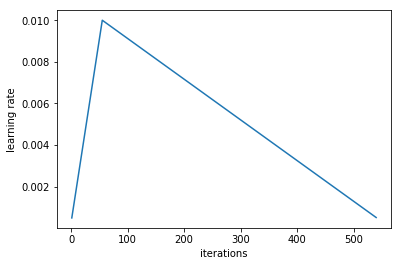

In [110]:
learn.sched.plot_lr()

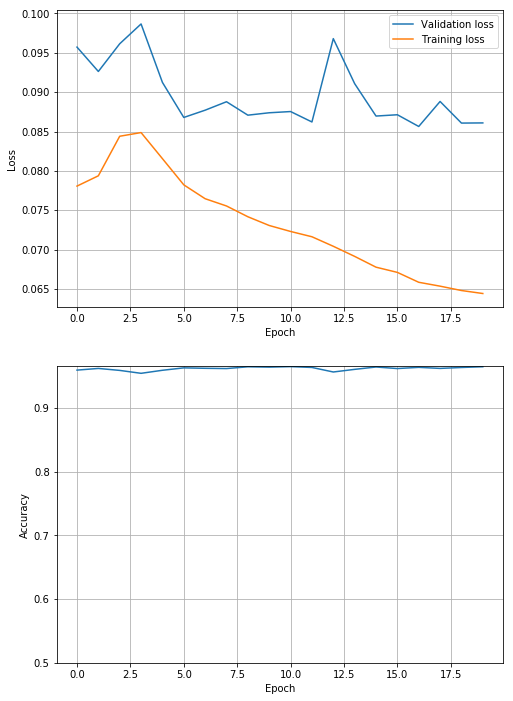

In [158]:
plot_training()

In [159]:
learn.save('128unet_2')

In [ ]:
learn.load('128unet_2')

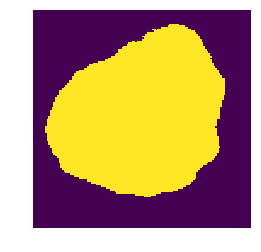

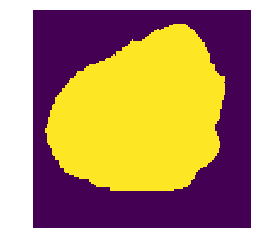

In [160]:
x,y = next(iter(mdata.val_dl))
py = to_np(learn.model(V(x)))

show_img(py[0]>0); show_img(y[0]);

In [163]:
x_den = denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


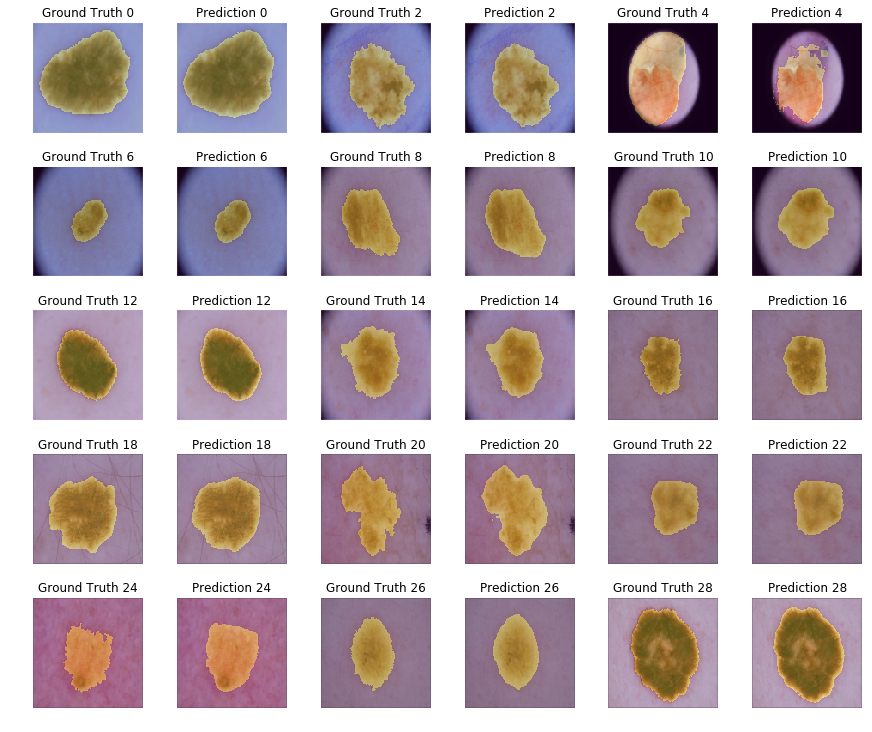

In [178]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax=show_img(x_den[i], ax=ax)
        show_img(y[i], ax=ax, alpha=0.3)
        ax.set_title(f'Ground Truth {i}')
    else:
        ax=show_img(x_den[i-1], ax=ax)
        show_img(py[i-1]>0, ax=ax, alpha=0.3)
        ax.set_title(f'Prediction {i-1}')
plt.tight_layout(pad=0.1)